In [1]:
import torch
from sparsemax import Sparsemax
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

class classifier(torch.nn.Module):
    def __init__(self):
        super(classifier, self).__init__()
        self.last_scores = None
        self.last_weights = None

        self.scoring_linear1 = torch.nn.Linear(768, 512)
        self.scoring_linear2 = torch.nn.Linear(512, 128)
        self.scoring_linear3 = torch.nn.Linear(128, 1)
        
        self.relu = torch.nn.ReLU(inplace = False)
        self.sparsemax = Sparsemax(dim = 0)

        self.classifying_linear1 = torch.nn.Linear(768, 512)
        self.classifying_linear2 = torch.nn.Linear(512, 128)
        self.classifying_linear3 = torch.nn.Linear(128, 1)
        
        self.sig = torch.nn.Sigmoid()

    def forward(self, x):
        self.last_scores = self.scoring_linear3(
            self.relu(self.scoring_linear2(
            self.relu(self.scoring_linear1(x))
            ))
        )

        # There appears to be a bug with the Sparsemax function.
        # Sparsemax only handles 2-dim tensors, therefore there is a code
        # that does:
        # input = input.transpose(0, self.dim)
        # which means if I have dim = 0, no transpose will happen, therefore I
        # need to transpose the scores first and transpose it back.
        self.last_weights = self.sparsemax(self.last_scores.T).T
        agg_out = torch.sum(self.last_weights * x, dim = 0, keepdim = True)

        result = self.classifying_linear3(
            self.relu(self.classifying_linear2(
            self.relu(self.classifying_linear1(agg_out))
            ))
        )
        return self.sig(result)

df_pos = pd.read_parquet("dcr_alpha_LTX051_LN1_M13_a-LTX051_LN1_M13_b.parquet")
df_neg = pd.read_parquet("dcr_HCW_0003_6M_1_alpha.parquet")


In [2]:
%%script --false
embeddings_pos = torch.from_numpy(df_pos.values).to(torch.float32)
embeddings_neg = torch.from_numpy(df_neg.values).to(torch.float32)
model = classifier()
criterion = torch.nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr = 1e-3)

pos_trainloss = []
neg_trainloss = []
train_loss = []

for i in tqdm(range(20)):
    ypred = model(embeddings_pos)
    loss_pos = criterion(torch.ones((1, 1)), ypred)
    pos_trainloss.append(loss_pos.data.tolist())

    ypred = model(embeddings_neg)
    loss_neg = criterion(torch.zeros((1, 1)), ypred)
    neg_trainloss.append(loss_neg.data.tolist())

    loss = loss_pos + loss_neg
    train_loss.append(loss.data.tolist())

    optim.zero_grad()
    loss.backward()
    optim.step()

plt.scatter([i for i in range(len(train_loss))], train_loss, marker = ".", c = "b")
plt.scatter([i for i in range(len(pos_trainloss))], pos_trainloss, marker = ".", c = "r")
plt.scatter([i for i in range(len(neg_trainloss))], neg_trainloss, marker = ".", c = "g")
plt.show()

Couldn't find program: '--false'


  0%|          | 0/20 [00:00<?, ?it/s]

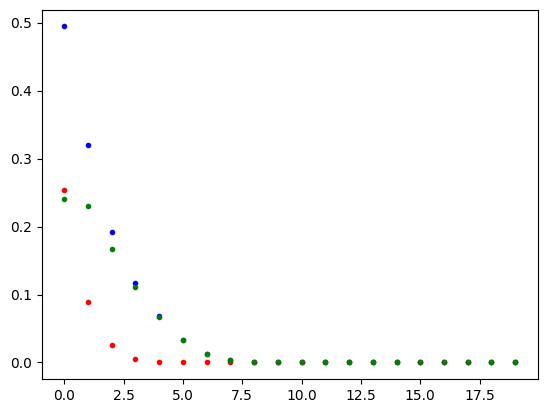

In [4]:
embeddings_pos = torch.from_numpy(df_pos.values).to(torch.float32).cuda()
embeddings_neg = torch.from_numpy(df_neg.values).to(torch.float32).cuda()
model = classifier().cuda()
criterion = torch.nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr = 1e-3)

pos_trainloss = []
neg_trainloss = []
train_loss = []

for i in tqdm(range(20)):
    ypred = model(embeddings_pos)
    loss_pos = criterion(torch.ones((1, 1)).cuda(), ypred)
    pos_trainloss.append(loss_pos.data.tolist())

    ypred = model(embeddings_neg)
    loss_neg = criterion(torch.zeros((1, 1)).cuda(), ypred)
    neg_trainloss.append(loss_neg.data.tolist())

    loss = loss_pos + loss_neg
    train_loss.append(loss.data.tolist())

    optim.zero_grad()
    loss.backward()
    optim.step()

plt.scatter([i for i in range(len(train_loss))], train_loss, marker = ".", c = "b")
plt.scatter([i for i in range(len(pos_trainloss))], pos_trainloss, marker = ".", c = "r")
plt.scatter([i for i in range(len(neg_trainloss))], neg_trainloss, marker = ".", c = "g")
plt.show()

In [ ]:
import numpy as np
import math
from numpy.matlib import repmat
import sys
import matplotlib 
import matplotlib.pyplot as plt
from scipy.io import loadmat
import time
import os
import warnings
sys.path.append('')
warnings.filterwarnings("ignore", category=DeprecationWarning) 


# load in some binary test data (labels are -1, +1)
data = loadmat("ion.mat")
xTrIon  = data['xTr'].T
yTrIon  = data['yTr'].flatten()
xTeIon  = data['xTe'].T
yTeIon  = data['yTe'].flatten()

class TreeNode(object):
    """Tree class.
    
    (You don't need to add any methods or fields here but feel
    free to if you like. Our tests will only reference the fields
    defined in the constructor below, so be sure to set these
    correctly!)
    """
    
    def __init__(self, left, right, parent, cutoff_id, cutoff_val, prediction):
        self.left = left
        self.right = right
        self.parent = parent
        self.cutoff_id = cutoff_id
        self.cutoff_val = cutoff_val
        self.prediction = prediction

def spiraldata(N=300):
    r = np.linspace(1,2*np.pi,N)
    xTr1 = np.array([np.sin(2.*r)*r, np.cos(2*r)*r]).T
    xTr2 = np.array([np.sin(2.*r+np.pi)*r, np.cos(2*r+np.pi)*r]).T
    xTr = np.concatenate([xTr1, xTr2], axis=0)
    yTr = np.concatenate([np.ones(N), -1 * np.ones(N)])
    xTr = xTr + np.random.randn(xTr.shape[0], xTr.shape[1])*0.2
    
    xTe = xTr[::2,:]
    yTe = yTr[::2]
    xTr = xTr[1::2,:]
    yTr = yTr[1::2]
    
    return xTr,yTr,xTe,yTe

xTrSpiral,yTrSpiral,xTeSpiral,yTeSpiral=spiraldata(150)

def sqsplit(xTr,yTr,weights=None):
    """Finds the best feature, cut value, and loss value.
    
    Input:
        xTr:     n x d matrix of data points
        yTr:     n-dimensional vector of labels
        weights: n-dimensional weight vector for data points
    
    Output:
        feature:  index of the best cut's feature
        cut:      cut-value of the best cut
        bestloss: loss of the best cut
    """
    N,D = xTr.shape
    assert D > 0 # must have at least one dimension
    assert N > 1 # must have at least two samples
    if weights is None: # if no weights are passed on, assign uniform weights
        weights = np.ones(N)
    weights = weights/sum(weights) # Weights need to sum to one (we just normalize them)
    bestloss = np.inf
    feature = np.inf
    cut = np.inf
    
    # YOUR CODE HERE
    for i in range(D):
        xTr_idx = np.argsort(xTr[:, i])
        xTr_sort = xTr[xTr_idx, i]
        yTr_sort = yTr[xTr_idx]
        ws_sorted = weights[xTr_idx]
        
        QRk = ws_sorted.T @ np.power(yTr_sort, 2)
        PRk = ws_sorted.T @ yTr_sort
        QLk, PLk, WLk = 0, 0, 0
        WRk = 1

        for j in range(N - 1):
            # We apply the efficient update rule here.
            WRk -= ws_sorted[j]
            PRk -= ws_sorted[j] * yTr_sort[j]
            QRk -= ws_sorted[j] * np.power(yTr_sort[j], 2)
            WLk += ws_sorted[j]
            PLk += ws_sorted[j] * yTr_sort[j]
            QLk += ws_sorted[j] * np.power(yTr_sort[j], 2)

            # Calculate loss
            loss = (QLk - (PLk ** 2 / WLk)) + (QRk - (PRk ** 2 / WRk))
            
            if xTr_sort[j] != xTr_sort[j + 1] and loss < bestloss:
                bestloss = loss
                feature = i
                cut = (xTr_sort[j] + xTr_sort[j + 1]) / 2
    
    return feature, cut, bestloss

def cart(xTr,yTr,depth=np.inf,weights=None):
    """Builds a CART tree.
    
    The maximum tree depth is defined by "maxdepth" (maxdepth=2 means one split).
    Each example can be weighted with "weights".

    Args:
        xTr:      n x d matrix of data
        yTr:      n-dimensional vector
        maxdepth: maximum tree depth
        weights:  n-dimensional weight vector for data points

    Returns:
        tree: root of decision tree
    """
    n,d = xTr.shape
    if weights is None:
        w = np.ones(n) / float(n)
    else:
        w = weights
    
    # YOUR CODE HERE
    preds = np.dot(w, yTr)
    if depth == 1 or all(yTr == yTr[0]) or yTr.shape[0] < 2:
        return TreeNode(*(None, ) * 5, preds)

    feature, cut, bestloss = sqsplit(xTr, yTr)
    L = np.where(xTr[:, feature] <= cut)
    R = np.where(xTr[:, feature] > cut)

    wL = w[L]
    wR = w[R]
    
    carttree = TreeNode(*(None, ) * 3, feature, cut, preds)
    
    carttree.left = cart(
        xTr = xTr[L], 
        yTr = yTr[L], 
        depth = depth - 1,
        weights = wL / np.sum(wL)
    )

    carttree.right = cart(
        xTr = xTr[R],
        yTr = yTr[R], 
        depth = depth - 1,
        weights = wR / np.sum(wR)
    )

    if carttree.left is not None and carttree.right is not None:
        carttree.left.parent = carttree
        carttree.right.parent = carttree
    
    return carttree


def boosttree(x,y,maxiter=100,maxdepth=2):
    """Learns a boosted decision tree.
    
    Input:
        x:        n x d matrix of data points
        y:        n-dimensional vector of labels
        maxiter:  maximum number of trees
        maxdepth: maximum depth of a tree
        
    Output:
        forest: list of TreeNode decision trees of length m
        alphas: m-dimensional weight vector
        
    (note, m is at most maxiter, but may be smaller,
    as dictated by the Adaboost algorithm)
    """
    assert np.allclose(np.unique(y), np.array([-1,1])); # the labels must be -1 and 1 
    n,d = x.shape
    weights = np.ones(n) / n
    preds   = None
    forest  = []
    alphas  = []

    # YOUR CODE HERE
    for t in range(maxiter):
        tree = cart(x, y, maxdepth, weights)
        ypred = evaltree(tree, x)
        error = weights[np.sign(ypred) != y].sum()
        if error < 0.5:
            forest.append(tree)
            alphas.append(0.5 * np.log((1 - error) / error))
            weights = weights * np.exp(-alphas[-1] * y * ypred) / (2 * np.sqrt(error * (1 - error)))
        else:
            break
    
    return forest, alphas

In [10]:
a = [1,2,3,4,5]
import pandas as pd
pd.DataFrame(a).to_csv("a.csv", index = False, header = False)